# Image classification using Convolutional Neural network

importing libraries

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

Downloading training and test dataset of CIFAR10

In [2]:
train_dataset = CIFAR10(root='data/CIFAR10/train/',train=True, transform=ToTensor(), download=True)
test_dataset = CIFAR10(root='data/CIFAR10/test/',train=False, transform=ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_dataset),len(test_dataset)

(50000, 10000)

Listing out all the classes in the dataset

In [4]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


defining a function to show image

In [5]:
def show_image(img, label):
    print(f'Label : {train_dataset.classes[label]} , {label}')
    plt.imshow(img.permute(1,2,0))

Let's look at couple of images from dataset. As you can tell, the `32x32 px` images are quiet difficult to identify, even for the human eye.

Label : frog , 6


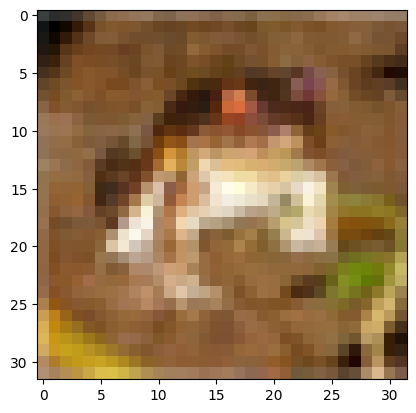

In [6]:
show_image(*train_dataset[0])

Label : truck , 9


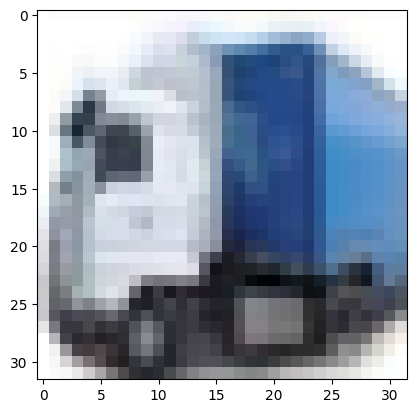

In [7]:
show_image(*train_dataset[1099])

## Training and validation Datasets

while building real world machine learning models, it is quiet common to split the dataset into 3 parts:

1. $\textbf{Training set}$ : used to train the model i.e., compute the loss and adjust the weights of the model using gradient descent.

2. $\textbf{Validation set}$ : used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.

3. $\textbf{Test set}$ : used to compare different models, or different types of modelling approaches, and report the final accuracy of the model.

Since there's is no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTroch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generation.

In [8]:
random_seed = 42
torch.manual_seed(random_seed);

In [9]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(45000, 5000)

In [10]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different batch, since the sampler shuffles the indices before creating batches.

In [11]:
def show_batch(dl):
    for images,_ in dl:
        _, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

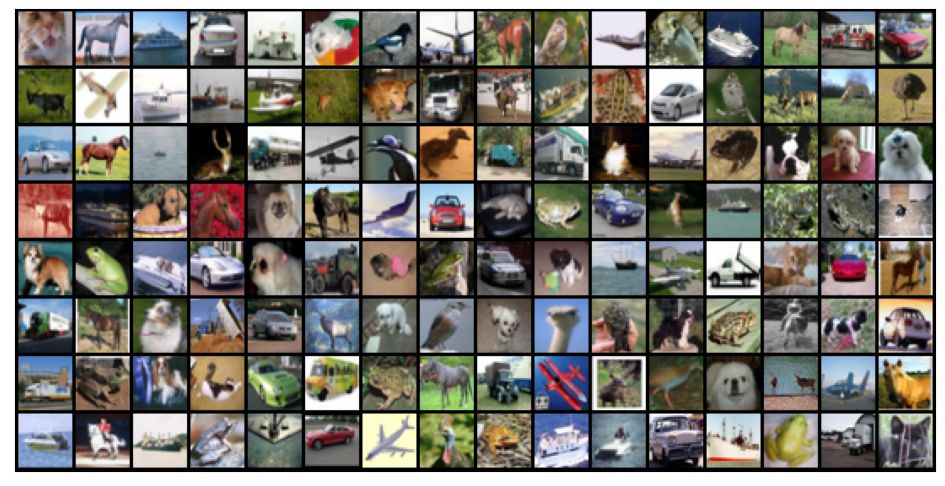

In [12]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

In our Feed_forward_neuralnetwork model, we defined a deep neural network with fully-connected layers using `nn.Linear`. For this we will use a convolutional neural network, using the `nn.conv2d` class from PyTorch.

Let us implement a convolution operation on a 1 channel image with a `3x3` kernel

In [13]:
def apply_kernel(image,kernel):
    ri,ci = image.shape         # image dimension
    rk,ck = kernel.shape        # kernel dimension
    ro,co = ri-rk+1, ci-ck+1    # output dimension
    
    output = torch.zeros([ro,co])

    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)

    return output

In [14]:
sample_image = torch.tensor([
    [3,3,2,1,0],
    [0,0,1,3,1],
    [3,1,2,2,3],
    [2,0,0,2,2],
    [2,0,0,0,1]
],dtype=torch.float32)

sample_kernel = torch.tensor([
    [0,1,2],
    [2,2,0],
    [0,1,2]
],dtype=torch.float32)

apply_kernel(sample_image,sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

for multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise.

there are certain advantages offered by convolutional layers when working with image data:

1. $\textbf{Fewer parameters : }$ A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.

2. $\textbf{Sparsity of connections}$: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.

3. $\textbf{Parameter sharing and spatial invariance }$: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a max-pooling layers to progressively decrease the height and width of the output tensor from each convolution layer.

In [15]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(2,2)
)

In [16]:
for images, labels in train_dl:
    print(f'images.shape : {images.shape}')
    out = simple_model(images)
    print(f'out.shape : {out.shape}')
    break

images.shape : torch.Size([128, 3, 32, 32])
out.shape : torch.Size([128, 8, 16, 16])


Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training and validation.

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs ,dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images,labels = batch
        out = self(images)                  # generate predictions
        loss = F.cross_entropy(out,labels)  # calculate loss

        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        acc = accuracy(out,labels)          # Calculate accuracies

        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = []
        batch_accs = []
        for x in outputs:
            batch_losses.append(x['val_loss'])
            batch_accs.append(x['val_acc'])

        epoch_loss = torch.stack(batch_losses).mean() # combining losses
        epoch_acc = torch.stack(batch_accs).mean()    # Combining accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print(f"Epoch [{epoch+1}], train_loss : {result['val_loss']}, val_acc : {result['val_acc']}")


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [19]:
class cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input : 3 x 32 x 32
            nn.Conv2d(3,32,kernel_size=3,stride=1, padding=1),
            # output : 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            # output : 64 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output : 64 x 16 x 16

            nn.Conv2d(64,128,kernel_size=3,stride=1, padding=1),
            # output : 128 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            # output : 128 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output : 128 x 8 x 8

            nn.Conv2d(128,256,kernel_size=3,stride=1, padding=1),
            # output : 256 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            # output : 256 x 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output : 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self, xb):
        return self.network(xb)

In [20]:
model = cifar10CnnModel()
model

cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities fot the 10 target classes (after applying softmax), and the class with the highest probabilities is choosen as the label predicted by the model for the input image.

In [21]:
for images, labels in train_dl:
    print(f'images.shape : {images.shape}')
    out = model(images)
    print(f'out.shape : {out.shape}')
    print(f'out[o] : {out[0]}')
    break

images.shape : torch.Size([128, 3, 32, 32])
out.shape : torch.Size([128, 10])
out[o] : tensor([ 0.0241, -0.0468,  0.0068,  0.0194,  0.0043, -0.0599, -0.0187, -0.0242,
         0.0428, -0.0164], grad_fn=<SelectBackward0>)


To seemlessly use a GPU, if one is availaible, we define a helper function and helper class `DeviceDataLoader` to move out model and data to the GPU as required.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [23]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to GPU (if availaible)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training the Model

We'll define two function: `fit` and `evaluate` to trian the model using gradient descent and evaluate its performance on the validation set.

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]

    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    
    return history


Before we befin training, let's instanitate the mmodel once again and see how it performs on the validation set with the initial set of parameters.

In [25]:
model = to_device(cifar10CnnModel(), device)
evaluate(model, val_dl)

{'val_loss': 2.302680253982544, 'val_acc': 0.10366497933864594}

In [26]:
num_epoch = 10
opt_func = torch.optim.Adam
lr = 1e-3

In [27]:
history = fit(num_epoch, lr, model, train_dl, val_dl, opt_func)

Epoch [1], train_loss : 1.4219110012054443, val_acc : 0.4705422818660736
Epoch [2], train_loss : 1.0650043487548828, val_acc : 0.6135684847831726
Epoch [3], train_loss : 0.8578072786331177, val_acc : 0.6955997347831726
Epoch [4], train_loss : 0.7723706960678101, val_acc : 0.7176240682601929
Epoch [5], train_loss : 0.6818815469741821, val_acc : 0.7615119218826294
Epoch [6], train_loss : 0.7112754583358765, val_acc : 0.7578240036964417
Epoch [7], train_loss : 0.7258860468864441, val_acc : 0.7617762088775635
Epoch [8], train_loss : 0.7764320373535156, val_acc : 0.7751033902168274
Epoch [9], train_loss : 0.8244057893753052, val_acc : 0.7724034786224365
Epoch [10], train_loss : 0.9604307413101196, val_acc : 0.7822610139846802


We can also plot the validation set accuracies to study how the model improvs over time

In [28]:
def plot_accuracies(history):
    accuracy = [x['val_acc'] for x in history]
    plt.plot(accuracy, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

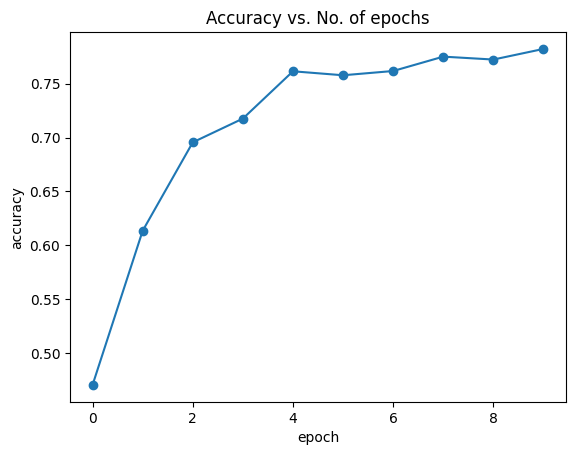

In [29]:
plot_accuracies(history)

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. Of epochs');

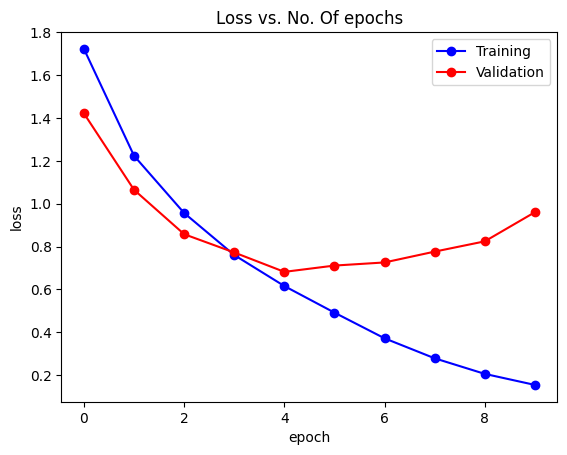

In [31]:
plot_losses(history)

Initially, both the training and validation losses seem to decrease over time. However, if you train the model fot long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing and even starts to increase after a certain point!

This phenomenon is called $\textbf{overfitting}$, and its the no. 1 why many machine learining models give rather terrible result on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn pattern are unique to the training data, sometimes even memorizing specific trainning examples.

Because of this, the model does not generalize well to previously unseen data.

Following are some common stragegies for avoiding overfitting:

1. Gathering and generating more training data, or adding noise to it
2. using regularization techniques like batch normalization and dropout
3. Early  stopping of model's training, when validation loss starts to increase.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also good idea to look at model's result on some sample images, Let's test out our model with some images from the predefined test dataset of 10000 images. 

In [32]:
def predict_image(img, model):
    # convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get prediction from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim = 1)

    return test_dataset.classes[preds[0].item()]

Label : cat, Predicted : cat


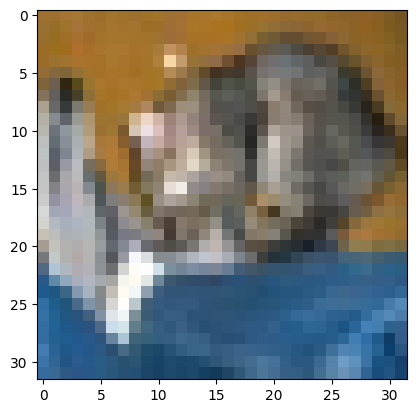

In [34]:
img,label = test_dataset[0]
plt.imshow(img.permute(1,2,0))
print(f'Label : {test_dataset.classes[label]}, Predicted : {predict_image(img,model)}')

Label : ship, Predicted : ship


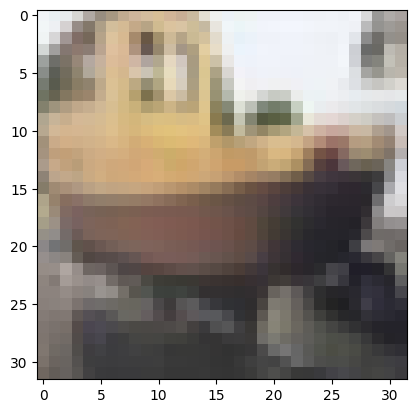

In [36]:
img,label = test_dataset[1002]
plt.imshow(img.permute(1,2,0))
print(f'Label : {test_dataset.classes[label]}, Predicted : {predict_image(img,model)}')

Label : deer, Predicted : deer


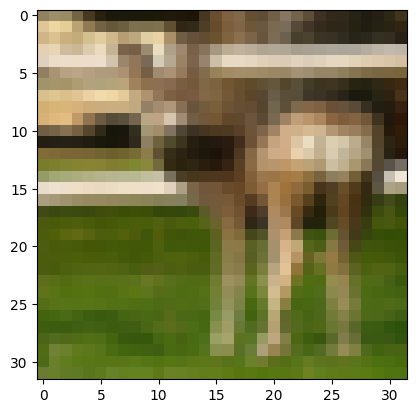

In [39]:
img,label = test_dataset[6153]
plt.imshow(img.permute(1,2,0))
print(f'Label : {test_dataset.classes[label]}, Predicted : {predict_image(img,model)}')

In [40]:
test_loader = DeviceDataLoader(DataLoader(train_dataset,batch_size*2), device)
result = evaluate(model,test_loader)
result

{'val_loss': 0.17241676151752472, 'val_acc': 0.952531099319458}

## Saving and loading the model

In [41]:
torch.save(model.state_dict(),'models/cifar10-cnn.pth')